### Van Leer Integrator
By

$\textit{Ian Boshoff}$

$\textit{Francisco Jabier Polanco Rodríguez}$

In [1]:
## Code given by Roch Smets, researcher in Laboratoire des physiques des Plasmas at École Polytechnique de Paris.
# -*- coding: utf-8 -*-
"""5pyp05_test_suite.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1WR7cjGv7clExhZRM_fNQ8ns4Mci1R3VQ

Tests suit for Hyperbolic Conservations Laws
============================================
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from tqdm import tqdm
"""# Support class"""

class TestHCL():
    """
    This is the support class for the 5 tests where are defined
    :param tag : index of the test (1 <= tag <= 5)
    :param tFinal : final time for the time integration of the equation
    :param domain : 2-elements tuple containing the domain of the simulation
    :param nx : number of grid points
    :param nu : ratio dt / dx which then define the time step
    :param flux : callable for the flux function
    :param u0 : callable for the initial u function
    :param uFinal : analytical profile of the solution at tFinal
    """
    def __init__(self, tag=None, tFinal=0, domain=(-1.0,+1.0), nx=0, nu=0.8, flux=lambda x :0, u0=lambda x:0, a=None):
        assert(isinstance(tag, int))
        assert(tag>0)
        assert(tag<=5)
        self.tag=tag
        self.time=tFinal
        self.domain=domain
        self.nx=nx
        self.nu=nu
        self.flux=flux
        self.u0=u0
        self.dx=(domain[1]-domain[0])/nx
        self.dt=nu*self.dx
        self.a=a
        self.x=np.linspace(domain[0], domain[1], nx)


    def __repr__(self):
        return f"""...................................................
{"Tag number":>24} : {self.tag}
{"Final time":>24} : {self.tFinal}
{"domain":>24} : {self.domain}
{"Number of grid points":>24} : {self.nx}
{"nu ":>24} : {self.nu}
{"dx ":>24} : {self.dx}
{"dt ":>24} : {self.dt}
{"a (wave speed) ":>24} : {self.a}"""

C:\Users\Pacopol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here we implement a Van-Leer integrator of the advection equation

\begin{equation}
    \partial_tu(x,t)+\partial_x f(x,t) = \partial_tu(x,t)+a(u)\partial_x u(x,t) = 0.
\end{equation}

This integrator works with the following scheme, with $n$ the index representing the time t ($t_n$) and $j$ the index representing the $n^{th}$ position in the grid $x^{n}$ :

\begin{equation}
    u_j^{n+1}=u_j^{n}+\frac{\Delta t}{\Delta x}\left(F_{Lax\;Wendroff\;j}^{n}+\frac{\eta_j^n}{2}\left(F_{Beam\;Warming\;j}^n-F_{Lax\;Wendroff\;j}^{n}\right)\right),
\end{equation}

being $\eta_j^n$ defined by 

\begin{equation}
    \eta_j^n=\frac{|r_j^n|+r_j^n}{|r_j^n|+1}\;\;\;and\;\;\;r_j^n = \frac{u_{j}^n-u_{j-1}^n}{u_{j+1}^n-u_{j}^n}.
\end{equation}

The $F_{Lax\;Wendroff\;j}^{n}$ and $F_{Beam\;Warming\;j}^n$ are the Lax Wendroff and the Beam Warming schemes. The Lax Wendroff scheme works well in the case of an smooth $u(x,t)$ and the other in the case of a discontinuous function. The function $\eta(x,y)$ is a function that gives an idea of the smoothness of $u(x,t)$. They are both defined by :

\begin{equation}
    F_{Lax\;Wendroff\;j}^{n}=F_{Lax\;Wendroff\;j+1/2}^{n}-F_{Lax\;Wendroff\;j-1/2}^{n}=\frac12\left[f(u_{j+1}^n)-f(u_{j-1}^n)\right]-\frac{a^2}{2}\frac{\Delta t}{\Delta x}\left[u_{j+1}-2u_j^n+u_{j-1}^n\right],
\end{equation}
and
\begin{equation}
    F_{Beam\;Warming\;j}^{n}=F_{Beam\;Warming\;j+1/2}^{n}-F_{Beam\;Warming\;j-1/2}^{n}=\frac12\left[3f(u_{j}^n)-4f(u_{j-1}^n)+f(u_{j-2}^n)\right]-\frac{a^2}{2}\frac{\Delta t}{\Delta x}\left[u_{j}-2u_{j-1}^n+u_{j-2}^n\right].
\end{equation}

In [2]:
def Van_Leer_integrator(u0:np.array,dx,dt,flux,a,tFinal,epsilon = 1e-60):
    N = np.int32(tFinal/dt)
    r = np.zeros((u0.shape[0]))
    eta = np.zeros((u0.shape[0]))
    F_lax = np.zeros((u0.shape[0]))
    F_bea = np.zeros((u0.shape[0]))

    u = np.concatenate((u0[:,np.newaxis],np.zeros((u0.shape[0],N))),axis = 1)
    J = len(u0)
    for k in tqdm(range(1,N+1),desc = 'Integrating equation'):
        for j in range(J):
            if j == J-1:
                r[j] = (u[j,k-1]-u[j-1,k-1])/(u[0,k-1]-u[j,k-1] + epsilon)
                F_lax[j] = 0.5*(flux(u[0,k-1]) - flux(u[j-1,k-1])) - 0.5*a(u[j,k-1])**2*dx**-1*dt*(u[0,k-1]-2*u[j,k-1]+u[j-1,k-1])
            else:
                r[j] = (u[j,k-1]-u[j-1,k-1])/(u[j+1,k-1]-u[j,k-1] + epsilon)
                F_lax[j] = 0.5*(flux(u[j+1,k-1]) - flux(u[j-1,k-1])) - 0.5*a(u[j,k-1])**2*dx**-1*dt*(u[j+1,k-1]-2*u[j,k-1]+u[j-1,k-1])
            F_bea[j] = 0.5*(3*flux(u[j,k-1]) - 4*flux(u[j-1,k-1]) + flux(u[j-2,k-1])) - 0.5*a(u[j,k-1])**2*dx**-1*dt*(u[j,k-1]-2*u[j-1,k-1]+u[j-2,k-1])
        eta = (np.abs(r) + r)/(np.abs(r) + 1)
        u[:,k] = u[:,k-1] - dx**-1*dt*(F_lax+0.5*eta*(F_bea-F_lax))
    return u


We now test this integrator in 5 different test cases with several flux functions $f(u)$ and their respective $a(u)$ asociated to the non-conservative form $\partial_x f=a\partial_x u$. The first test is the following. The flux function is defined by $\boxed{f(u)=u}$ and by $\boxed{a(u) = 1}$, it gives an advection of $u(x,t)$ for any $u_0(x)$, and consequently $u(x,t)=u(x-t)$. Let see what happens if we inject $u_0(x)=\sin(\pi x)$ for 30 time periods to see how the function advects. What we expect is to see the final velocity at the same point than at $t=0$.

TEST 1
---

Integrating equation: 100%|████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 5440.17it/s]


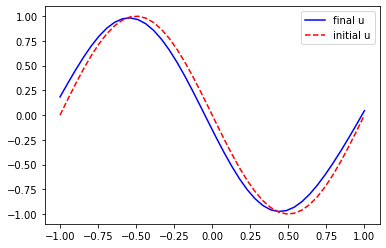

In [3]:
"""# Test 1 :"""

class Test1(TestHCL):
    def __init__(self):
        super().__init__(tag=1, tFinal = 30, nx=40, flux=lambda x:x, u0=lambda x:-np.sin(np.pi*x), a=lambda x:1)
        self.uFinal=self.u0(self.x)
t1=Test1()
u0 = np.array(t1.u0(np.linspace(-1,+1,t1.nx)))
x = t1.x
u = Van_Leer_integrator(u0,t1.dx,t1.dt,t1.flux,t1.a,t1.time)
plt.plot(x,u[:,-1],'b-',label = 'final u')    
plt.plot(x,u0,'r--',label = 'initial u')
plt.legend()

TEST 2
---

For the second test, we are going to advect in the same way ($f(u)=u$ and $a(u)=1$) but with a step function $u_0(x)=\theta\left(x-\frac13\right)-\theta\left(\frac13-x\right)$ ($\theta$ is the Heviside distribution function). We use a grid of 40 points.

Integrating equation: 100%|██████████| 99/99 [00:00<00:00, 2688.31it/s]


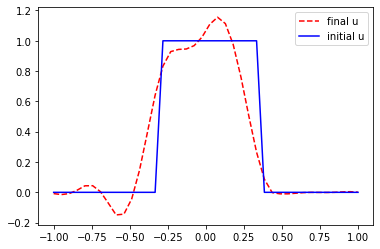

In [21]:
"""# Test 2 :"""

class Test2(TestHCL):
    def __init__(self):
        def flux(x):
            third=1.0/3.0
            return 0.5*(1+square((x+third)*np.pi,duty=third))
        super().__init__(tag=2, tFinal=4, nx=40, flux=lambda x:x, u0=lambda x:flux(x), a=lambda x:1)
        self.uFinal=self.u0(self.x) 
t2=Test2()
u0 = np.array(t2.u0(np.linspace(-1,+1,t2.nx)))
x = t2.x
u = Van_Leer_integrator(u0,t2.dx,t2.dt,t2.flux,t2.a,t2.time)
plt.plot(x,u[:,-2],'r--',label = 'final u')    
plt.plot(x,u0,'b',label = 'initial u')
plt.legend()

TEST 3
---

This is exactly the same adevection but with a grid of 600 points.

Integrating equation: 100%|██████████| 1499/1499 [00:07<00:00, 213.80it/s]


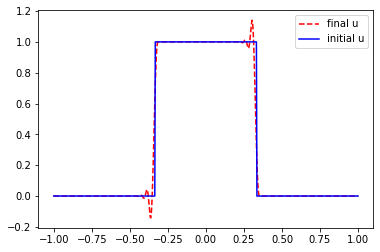

In [22]:
class Test3(TestHCL):
    def __init__(self):
        def flux(x):
            third=1.0/3.0
            return 0.5*(1+square((x+third)*np.pi,duty=third))
        super().__init__(tag=3, tFinal = 4, nx=600, flux=lambda x:x, u0=lambda x:flux(x), a=lambda x:1)
        self.uFinal=self.u0(self.x)
t3=Test3()
u0 = np.array(t3.u0(np.linspace(-1,+1,t3.nx)))
x = t3.x
u = Van_Leer_integrator(u0,t3.dx,t3.dt,t3.flux,t3.a,t3.time)
plt.plot(x,u[:,-2],'r--',label = 'final u')    
plt.plot(x,u0,'b',label = 'initial u')
plt.legend()

TEST 4
---

We are now going to change the flux function so that it is the same as we find in a fluid with no pressure or viscosity. The definitions are given by $\boxed{f(u)=u^2/2}$ and $\boxed{a(u)=u}$. The initial condition, as before, is a step function. We are going to plot also the theoretical final $u(x,t_{final})$.

Integrating equation: 100%|██████████| 14/14 [00:00<00:00, 2003.97it/s]


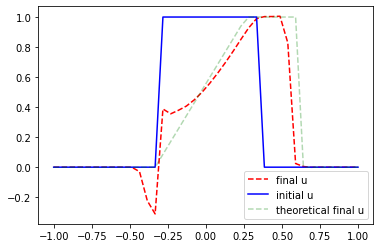

In [23]:
class Test4(TestHCL):
    def __init__(self):
        third=1.0/3.0
        def u0(x):
            return 0.5*(1+square((x+third)*np.pi,duty=third))
        super().__init__(tag=4, tFinal = 0.6, nx = 40, flux = lambda x:0.5*x*x, u0 = lambda x: u0(x), a = lambda x: x)
        self.uFinal=c=np.piecewise(self.x, [self.x <= -third, ((-third < self.x) & (self.x <= -third+0.6)), ((-third+0.6 < self.x) & (self.x <= third+0.6)), self.x > 0.6], [lambda x:0, lambda x:(third+x)/0.6, lambda x:1, lambda x:0])
t4=Test4()

u0 = np.array(t4.u0(np.linspace(-1,+1,t4.nx)))
x = t4.x
u = Van_Leer_integrator(u0,t4.dx,t4.dt,t4.flux,t4.a,t4.time)
plt.plot(x,u[:,-2],'r--',label = 'final u')    
plt.plot(x,u0,'b',label = 'initial u')
plt.plot(x,t4.uFinal,'g--',alpha = 0.3,label = 'theoretical final u')
plt.legend()

TEST 5
---

We see how the step is advected more or less as expected. In the second one, we are going to put a step that is going to have $u=-1$ as minimum value of $u_0(x)$ and $u=1$ for the maximum value of $u_0(x)$.In this case we expect that the part of the velocity field inside the step function will be advected to the right and the part outside the function will be advected to the left. Nevertheless it is not a totally physical initial condition, but is a highly non-continuous function. We expect to find a lot of instabilities, both physically and numerically.

Integrating equation: 100%|██████████| 7/7 [00:00<00:00, 2340.38it/s]


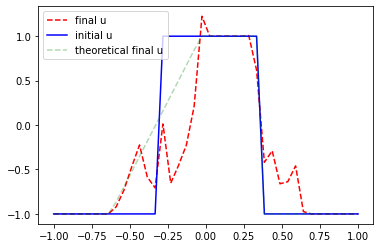

In [24]:
class Test5(TestHCL):
    def __init__(self):
        third=1.0/3.0
        def u0(x):
            return square((x+third)*np.pi,duty=third)
        super().__init__(tag=5, tFinal=0.3, nx = 40, flux=lambda x: 0.5*x*x, u0=lambda x: u0(x), a=lambda x:x)
        self.uFinal=c=np.piecewise(self.x, [self.x <= -third-0.3, ((-third-0.3 < self.x) & (self.x <= -third+0.3)), ((-third+0.3 < self.x) & (self.x <= third)), self.x > third], [lambda x:-1, lambda x:10*third*x+1+0.3*third, lambda x:1, lambda x:-1])
t5=Test5()

u0 = np.array(t5.u0(np.linspace(-1,+1,t5.nx)))
x = t5.x
u = Van_Leer_integrator(u0,t5.dx,t5.dt,t5.flux,t5.a,t5.time)

plt.plot(x,u[:,-2],'r--',label = 'final u')    
plt.plot(x,u0,'b',label = 'initial u')
plt.plot(x,t5.uFinal,'g--',alpha = 0.3,label = 'theoretical final u')
plt.legend()

VIDEOS
---
The final part of the code is just to create videos.

In [26]:
import imageio; import os


tests = [t1,t2,t3,t4,t5]
Name_vid = ['Advection_of_sinus_a=1',
            'Advection_step_a=1',
            'Advection_step_a=1_minor_grid',
            'Advection_step_a=u',
            'Advectio_nstep_u=+-1_a=u']


R=0
for test in tests:
    u = Van_Leer_integrator(u0,test.dx,test.dt,test.flux,test.a,test.time)
    frames = []
    for k in tqdm(range(u.shape[1]),desc = 'Creating video of test %i'%(R+1)):
        fig = plt.figure()
        plt.plot(x,u[:,k],'r--',label = 'final u')    
        plt.plot(x,u0,'b',label = 'initial u')
        if R>3:
            plt.plot(x,test.uFinal,'g--',alpha = 0.3,label = 'theoretical final u')
        plt.legend()
        name = 'frame%i.png'%(k)
        fig.savefig(name)
        plt.close('all')
        frames.append(name)
    with imageio.get_writer(Name_vid[R] + '.mp4',fps = 20) as writer:
        for i in range(0, len(frames)-1):
            image = imageio.imread(frames[i])
            writer.append_data(image)
            os.remove(frames[i])
    R += 1

Creating video of test 5: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]
